# Connect to Drive & Read

In [ ]:
# pip install plotly==4.5.0

In [1]:
from google.colab import drive
import pandas as pd, numpy as np
from plotly import express as px
#  pip install -U kaleido

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_pickle("/content/drive/MyDrive/CMG - Crystal Prediction Project/Ternary Materials Point Group Prediction/Data/NOMAD_2/Classification_Data_8.pkl").dropna()
print(df.shape)
df.head()

(1381099, 24)


,Atomic Number 1,Atomic Number 2,Atomic Number 3,Element_1,Element_2,Element_3,Coefficient 1,Coefficient 2,Coefficient 3,formula_reduced,...,lattice_parameters,Oxidation 1,Oxidation 2,Oxidation 3,IonicRadius_1,IonicRadius_2,IonicRadius_3,IonizationPot1st_1,IonizationPot1st_2,IonizationPot1st_3
0,3,5,41,Li,B,Nb,4,1,1,BLi4Nb,...,"{'a': 6.71860936e-10, 'b': 6.71860936e-10, 'c'...",1,-1,-3,0.755440,1.048943,1.842691,5.3917,8.298,6.7589
1,4,5,41,Be,B,Nb,4,1,1,BBe4Nb,...,"{'a': 6.119642980000002e-10, 'b': 6.1196429800...",1,-1,-3,0.643658,1.048943,1.842691,9.3226,8.298,6.7589
2,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,...,"{'a': 5.458027e-10, 'b': 5.458027e-10, 'c': 5....",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589
3,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,...,"{'a': 5.420156379999999e-10, 'b': 5.4201563799...",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589
4,4,5,41,Be,B,Nb,2,1,1,BBe2Nb,...,"{'a': 4.660283620000524e-10, 'b': 8.41781306e-...",2,-1,-3,0.452080,1.048943,1.842691,9.3226,8.298,6.7589


**Config**

In [3]:
FEATURE_NAMES = [
#     "Atomic Number 1","Atomic Number 2","Atomic Number 3",
    "Coefficient 1", "Coefficient 2", "Coefficient 3", 
    "IonizationPot1st_1", "IonizationPot1st_2", "IonizationPot1st_3", 
    "Oxidation 1", "Oxidation 2", "Oxidation 3", # Used to be electronegativity 
    "IonicRadius_1", "IonicRadius_2", "IonicRadius_3"
]

GROUPERS = [
    "Atomic Number 1","Atomic Number 2","Atomic Number 3",
    "Coefficient 1", "Coefficient 2", "Coefficient 3"
]

# Y_NAME = 'crystal_system'
# Y_NAME = 'bravais_lattice'
# Y_NAME = 'point_group'
Y_NAME = 'space_group_number'
Y_lst = ['space_group_number', 'point_group', 'bravais_lattice', 'crystal_system']

# Preprocess

In [4]:
df['crystal_system'].replace(to_replace="trigonal", value="hexagonal", inplace=True)
df['space_group_number'] = df['space_group_number'].astype(int)

In [5]:
df_dedup = df[FEATURE_NAMES+[Y_NAME]].drop_duplicates().copy()
df_dedup[Y_NAME] = df_dedup[Y_NAME].astype(str)
df_dedup[Y_NAME].unique().shape

(207,)

In [30]:
df_dedup['space_group_number'].value_counts().iloc[:10].sum() / df_dedup['space_group_number'].shape[0]

0.5952252517741305

In [ ]:
# value_counts = df_dedup[Y_NAME].value_counts()
# value_counts.index = value_counts.index.astype(str)
# fig = px.bar(x=value_counts.index, y=value_counts.values)
# fig.update_layout( 
#     width=3000,
#     yaxis=dict(title='Count'),
#     xaxis=dict(
#         title='Space Group',
#         tickmode='linear',
#         tickangle=60,
#         type='category'
#     )
# )

In [ ]:
# df['Counter'] = 1

In [ ]:
# sun_chart_df = df.groupby(['crystal_system', 'bravais_lattice', 'point_group', 'space_group_number'])['Counter'].sum().reset_index()

In [ ]:
# import plotly.express as px
# fig = px.sunburst(sun_chart_df, path=['crystal_system', 'bravais_lattice', 'point_group'], values='Counter')
# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=1200,)

# fig.write_image("images/fig1.svg")
# fig.show()

# Base Experiment

1. Resample
2. Groupby (Multi-Labeled data)
3. Multi-Label Encoding
4. Train-Test Split
5. Train

In [ ]:
accepted_classes = (df_dedup[Y_NAME].value_counts() > 300).replace(False, np.nan).dropna().index.tolist()
df_filtered = df_dedup[df_dedup[Y_NAME].isin(accepted_classes)].copy()
df_filtered[Y_NAME] = df_filtered[Y_NAME].astype(int)

print("Previous Data Size:", df_dedup.shape[0])
print("New Data Size:", df_filtered.shape[0])
print("Number of Classes Left:", len(accepted_classes))

Previous Data Size: 1381099
New Data Size: 1372271
Number of Classes Left: 50


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

df_grouped2 = df_filtered.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

In [ ]:
ml_binner = MultiLabelBinarizer()
ml_binner.fit(df_grouped2[Y_NAME])
y = ml_binner.transform(df_grouped2[Y_NAME])
X = df_grouped2[FEATURE_NAMES].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# from keras.models import Sequential
# from keras import regularizers
# from keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense
# model = Sequential()
# model.add(Conv1D(15, 8, padding='same', activation='relu',input_shape=(12, 1), strides = 1,  kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Conv1D(30, 8, padding='same', activation='relu',kernel_regularizer = regularizers.l1_l2(l1=0.1, l2=0.1), strides=1))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(67, activation = 'softmax'))
# model.summary()

# model.compile()
# model.fit(X_train, y_train, batch_size=48, epochs=2)
# from keras.models import Model
# feature_vectors_model = Model(model.input, model.get_layer('dense_16').output)
# dtc_features = feature_vectors_model.predict(X_train)
# ...
# dtc_features_test = feature_vectors_model.predict(X_test)


In [ ]:
clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
calc_wba_wmcc_conf(y_test, y_pred)

(0.9537135371468893, 0.9018300248924094, 2907379, 253956, 20977, 24088)

In [ ]:
from sklearn.metrics import classification_report
target_names = ml_binner.classes_
print(classification_report(y_test, y_pred, target_names=[str(i) for i in target_names]))

              precision    recall  f1-score   support

           1       0.66      0.23      0.34       223
           2       0.68      0.26      0.37       275
           4       0.80      0.17      0.29        69
           6       0.81      0.89      0.85     10047
           8       0.91      0.96      0.93     12177
          10       0.93      0.98      0.96     12553
          11       0.74      0.23      0.35       114
          12       0.91      0.96      0.93     12619
          14       0.70      0.30      0.42       427
          15       0.74      0.40      0.52       290
          25       0.76      0.73      0.74      7246
          33       0.62      0.09      0.16        54
          35       0.83      0.91      0.87     10220
          36       0.72      0.36      0.48        73
          38       0.66      0.41      0.51      3007
          42       0.83      0.91      0.87      3506
          44       0.68      0.76      0.71     11098
          47       0.91    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Iterations

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

def prepare_train_test(df):
    ml_binner = MultiLabelBinarizer()
    ml_binner.fit(df[Y_NAME])
    y = ml_binner.transform(df[Y_NAME])
    X = df[FEATURE_NAMES].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test, ml_binner

def get_confusion(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return TN, TP, FN, FP


def calc_wba_wmcc_conf(y_true, y_pred):
    """Calculated the weighted balanced accuracy and mathews correlation coefficient
    """
    n_lst = []
    ba_lst = []
    mcc_lst = []
    tn_lst = []
    tp_lst = []
    fn_lst = []
    fp_lst = []
    for idx in range(y_true.shape[1]):
        class_true = y_true[:, idx]
        class_preds = y_pred[:, idx]
        N = sum(class_true)
        BA = balanced_accuracy_score(class_true, class_preds, adjusted=False)
        MCC = matthews_corrcoef(class_true, class_preds)
        TN, TP, FN, FP = get_confusion(class_true, class_preds)

        n_lst.append(N)
        mcc_lst.append(MCC)
        ba_lst.append(BA)

        tn_lst.append(TN)
        tp_lst.append(TP)
        fn_lst.append(FN)
        fp_lst.append(FP)

    weighted_balanced_acc = sum([n*ba for n,ba in zip(n_lst,ba_lst)]) / sum(sum(y_true))
    weighted_mcc = sum([n*mcc for n,mcc in zip(n_lst, mcc_lst)]) / sum(sum(y_true))
    sum_tn = sum(tn_lst)
    sum_tp = sum(tp_lst)
    sum_fn = sum(fn_lst)
    sum_fp = sum(fp_lst)

    return weighted_balanced_acc, weighted_mcc, sum_tn, sum_tp, sum_fn, sum_fp

def evaluate(y_true, y_pred):
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    WBA, WMCC, TN, TP, FN, FP = calc_wba_wmcc_conf(y_true, y_pred)
    metrics = {
        "WMCC": WMCC ,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "WBA": WBA,
        "TN":TN,
        "TP":TP, 
        "FN":FN,
        "FP":FP
    }
    return metrics

def filter_y(df, min_class_size):
    accepted_classes = (df[Y_NAME].value_counts() > min_class_size).replace(False, np.nan).dropna().index.tolist()
    df_filtered = df[df[Y_NAME].isin(accepted_classes)].copy()
    return df_filtered

In [7]:
df_main = df_dedup.copy()


In [ ]:
experiments = []
2**16

65536

In [ ]:
Y_NAME

'space_group_number'

In [8]:
# class_variables = ["crystal_system", "bravais_lattice", "point_group", "space_group_number"]
# class_variable_sizes = [6, 14, 32]

# crystal_system:  06 --------
# bravais_lattice: 14
# point_group:     32
df_main[Y_NAME].value_counts()[:50]

216    153259
225    106156
221    102283
166     68748
123     68739
65      68090
99      67814
12      63158
10      62561
119     61257
47      60773
8       60667
139     58528
44      55379
35      51281
6       50088
71      45098
25      35995
107     23279
156     22564
160     19170
42      17432
38      15188
187      8551
62       3492
14       2137
227      1997
63       1638
194      1626
148      1497
15       1466
2        1426
1        1098
69       1062
164      1028
129       829
55        816
189       800
11        669
141       560
186       534
191       508
127       476
59        462
193       378
36        373
140       357
74        343
4         334
33        307
Name: space_group_number, dtype: int64

In [9]:
df_filtered = filter_y(df_main, 50)
df_agg = df_filtered.groupby(FEATURE_NAMES)[Y_NAME].apply(list).reset_index()

df_agg.head()

,Coefficient 1,Coefficient 2,Coefficient 3,IonizationPot1st_1,IonizationPot1st_2,IonizationPot1st_3,Oxidation 1,Oxidation 2,Oxidation 3,IonicRadius_1,IonicRadius_2,IonicRadius_3,space_group_number
0,1,1,1,4.3407,5.2117,6.1083,-1,2,-1,1.792941,1.345410,1.806147,"[216, 107, 156]"
1,1,1,1,4.3407,5.2117,6.8251,1,1,-2,1.389265,1.588994,1.769692,"[216, 44, 42, 107, 156]"
2,1,1,1,4.3407,5.2117,7.2890,-1,2,-1,1.792941,1.345410,1.970947,"[216, 194, 42, 107, 156]"
3,1,1,1,4.3407,5.2117,7.4167,-1,2,-1,1.792941,1.345410,1.913548,"[216, 44, 107, 156]"
4,1,1,1,4.3407,5.2117,7.8800,-1,2,-1,1.792941,1.345410,1.431614,"[216, 42, 44, 107, 156]"


In [ ]:
# df_filtered.shape
# df_agg = df_filtered.groupby(FEATURE_NAMES)['space_group_number', 'point_group', 'bravais_lattice', 'crystal_system']
# df_agg.apply(lambda x: list(x['space_group_number'])+list(x['point_group'])+list(x['bravais_lattice'])+list(x['crystal_system'])).reset_index()

In [10]:
df_filtered[Y_NAME].value_counts()

216    153259
225    106156
221    102283
166     68748
123     68739
        ...  
204        53
29         53
205        53
147        53
130        53
Name: space_group_number, Length: 98, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x:x, lowercase=False)
X = vectorizer.fit_transform(df_agg['space_group_number'])

classes = vectorizer.get_feature_names_out().tolist()
df_counter = pd.DataFrame(data=X.todense(), columns=classes)
df_counter.head()

,1,10,100,101,102,104,105,106,107,108,...,88,89,9,91,92,94,95,96,97,99
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
co_occure_mat = X.T.dot(X).todense()
np.fill_diagonal(co_occure_mat, 0)

In [ ]:
co_occure_mat

matrix([[    0,    52,     0, ...,     0,     2,    32],
        [   52,     0,     0, ...,     0,     0, 62202],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    2,     0,     0, ...,     0,     0,     0],
        [   32, 62202,     0, ...,     0,     0,     0]], dtype=int64)

In [ ]:
df_cooc = pd.DataFrame(data=co_occure_mat, columns=classes, index=classes)
assert df_agg['space_group_number'].apply(lambda x: ("99" in x) and ("107" in x)).sum() == df_cooc.loc["107", "99"]
df_cooc.tail()


,1,10,100,101,102,104,105,106,107,108,...,88,89,9,91,92,94,95,96,97,99
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,32,62202,0,0,0,0,0,0,21,2,...,0,0,9,0,4,0,0,0,0,0


In [ ]:
a = df_cooc.stack()
a = a[a >= 30000].rename_axis(('source', 'target')).reset_index(name='weight')
a

,source,target,weight
0,10,119,55906
1,10,12,56810
2,10,123,62423
3,10,139,48855
4,10,166,62104
...,...,...,...
255,99,47,60474
256,99,6,49824
257,99,65,65502
258,99,71,44475


In [ ]:
# a['weight'] = a['weight'].apply(np.log2)

In [ ]:
a['source'].value_counts().shape

(17,)

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)

G.number_of_edges()

130

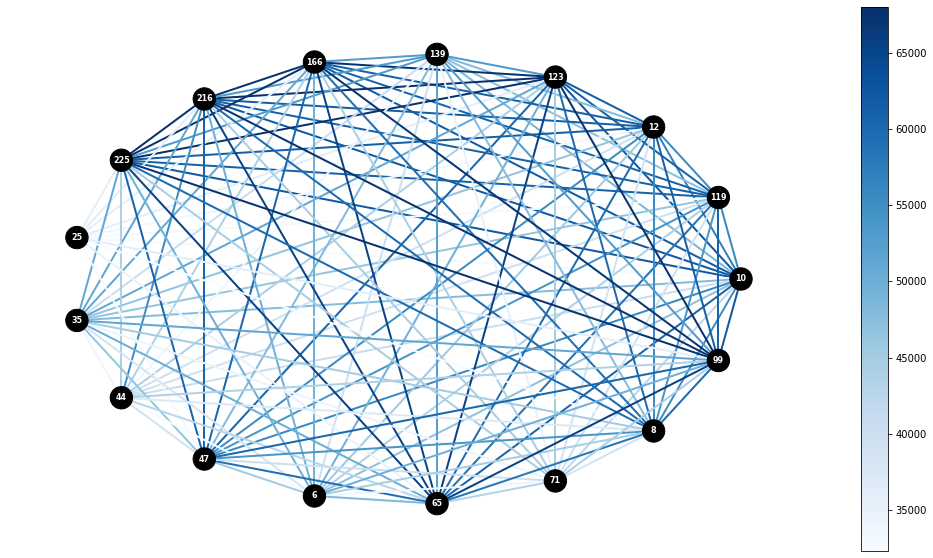

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(18,10))

node_sizes = [500 for (_,n_edges) in dict(nx.degree(G)).items()]
# node_sizes_lst = np.asarray(node_sizes)


edges = G.edges()
edge_colors = [G[u][v]['weight'] for u,v in edges]
vmin, vmax = min(edge_colors), max(edge_colors)
cmap=plt.cm.Blues

#draw the graph
# pos = nx.spring_layout(G, k=0.8, iterations=200)
pos = nx.circular_layout(G)

###########################

nx.draw(G, pos, node_color='black', edge_color=edge_colors, width=2, edge_cmap=cmap, node_size=node_sizes,
           with_labels=True, font_size = 8, font_weight = 'bold', font_color='white', vmin=vmin, vmax=vmax)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.show()

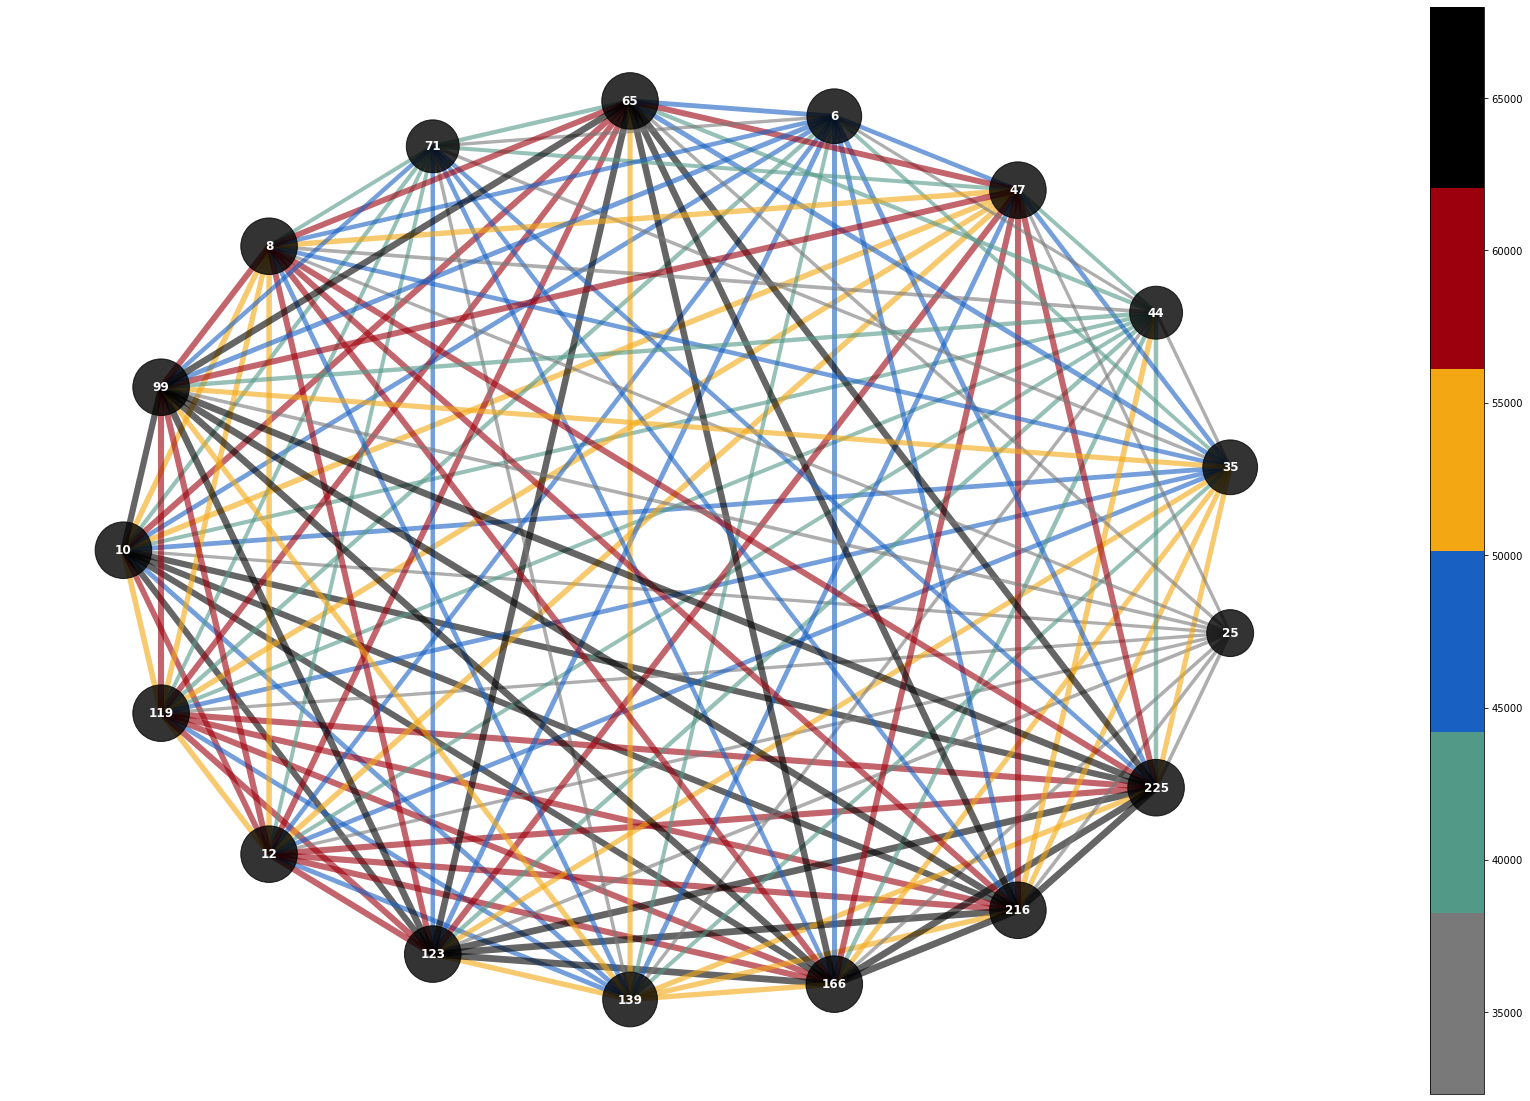

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.subplots(figsize=(30,20))

# NODES
nodelist = G.nodes()
node_sizes = [max(1000, n_edges*200) for (_,n_edges) in dict(nx.degree(G)).items()]
# EDGES
widths = nx.get_edge_attributes(G, 'weight')
edges = G.edges()
edge_colors = [G[u][v]['weight'] for u,v in edges]
vmin, vmax = min(edge_colors), max(edge_colors)
cmap=plt.cm.RdYlGn
cmap = ListedColormap(["#797979", "#539987", "#1860C2", "#F3A712", "#9C000C", "#000000"])

edge_widths = [max(0.4, width*0.0001) for width in list(widths.values())]



# GRAPH
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=node_sizes,
                       node_color='black',
                       alpha=0.8)

nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=edge_widths,
                       alpha=0.6, edge_color=edge_colors, edge_cmap=cmap)

nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='white', font_size = 12, font_weight = 'bold')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.box(False)
plt.savefig("Graph.svg", format="SVG")
plt.show()

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 26.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cc3877cc5a3faa2dc69005bce466ffbba828504c6ae6b41c1adbd2ca69e153a0
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=18bc31df5d87b9c42621525ebfc67ccecbe98d3b640c8e4cf18d229d1120d21e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
df_filtered

,Coefficient 1,Coefficient 2,Coefficient 3,IonizationPot1st_1,IonizationPot1st_2,IonizationPot1st_3,Oxidation 1,Oxidation 2,Oxidation 3,IonicRadius_1,IonicRadius_2,IonicRadius_3,space_group_number
0,4,1,1,5.3917,8.2980,6.7589,1,-1,-3,0.755440,1.048943,1.842691,216
1,4,1,1,9.3226,8.2980,6.7589,1,-1,-3,0.643658,1.048943,1.842691,216
2,2,1,1,9.3226,8.2980,6.7589,2,-1,-3,0.452080,1.048943,1.842691,216
3,2,1,1,9.3226,8.2980,6.7589,2,-1,-3,0.452080,1.048943,1.842691,225
4,2,1,1,9.3226,8.2980,6.7589,2,-1,-3,0.452080,1.048943,1.842691,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381094,1,2,1,8.2980,11.2603,14.5341,-1,2,-3,1.048943,0.361359,1.454877,17
1381095,1,2,1,8.2980,11.2603,14.5341,-1,2,-3,1.048943,0.361359,1.454877,115
1381096,1,1,3,9.3226,8.2980,11.2603,2,1,-1,0.452080,0.615119,1.065589,221
1381097,1,1,3,5.3917,9.3226,11.2603,1,2,-1,0.755440,0.452080,1.065589,221


In [ ]:
filter_sample01 = df_filtered.sample(frac=0.2).copy()
filter_sample01[FEATURE_NAMES]
filter_sample01[Y_NAME]


76617      123
535116     221
951746     221
623858     187
113769      35
          ... 
723954     123
576606     221
783824       6
1351958    221
324265      99
Name: space_group_number, Length: 276220, dtype: object

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(filter_sample01[FEATURE_NAMES].values)


/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: sp

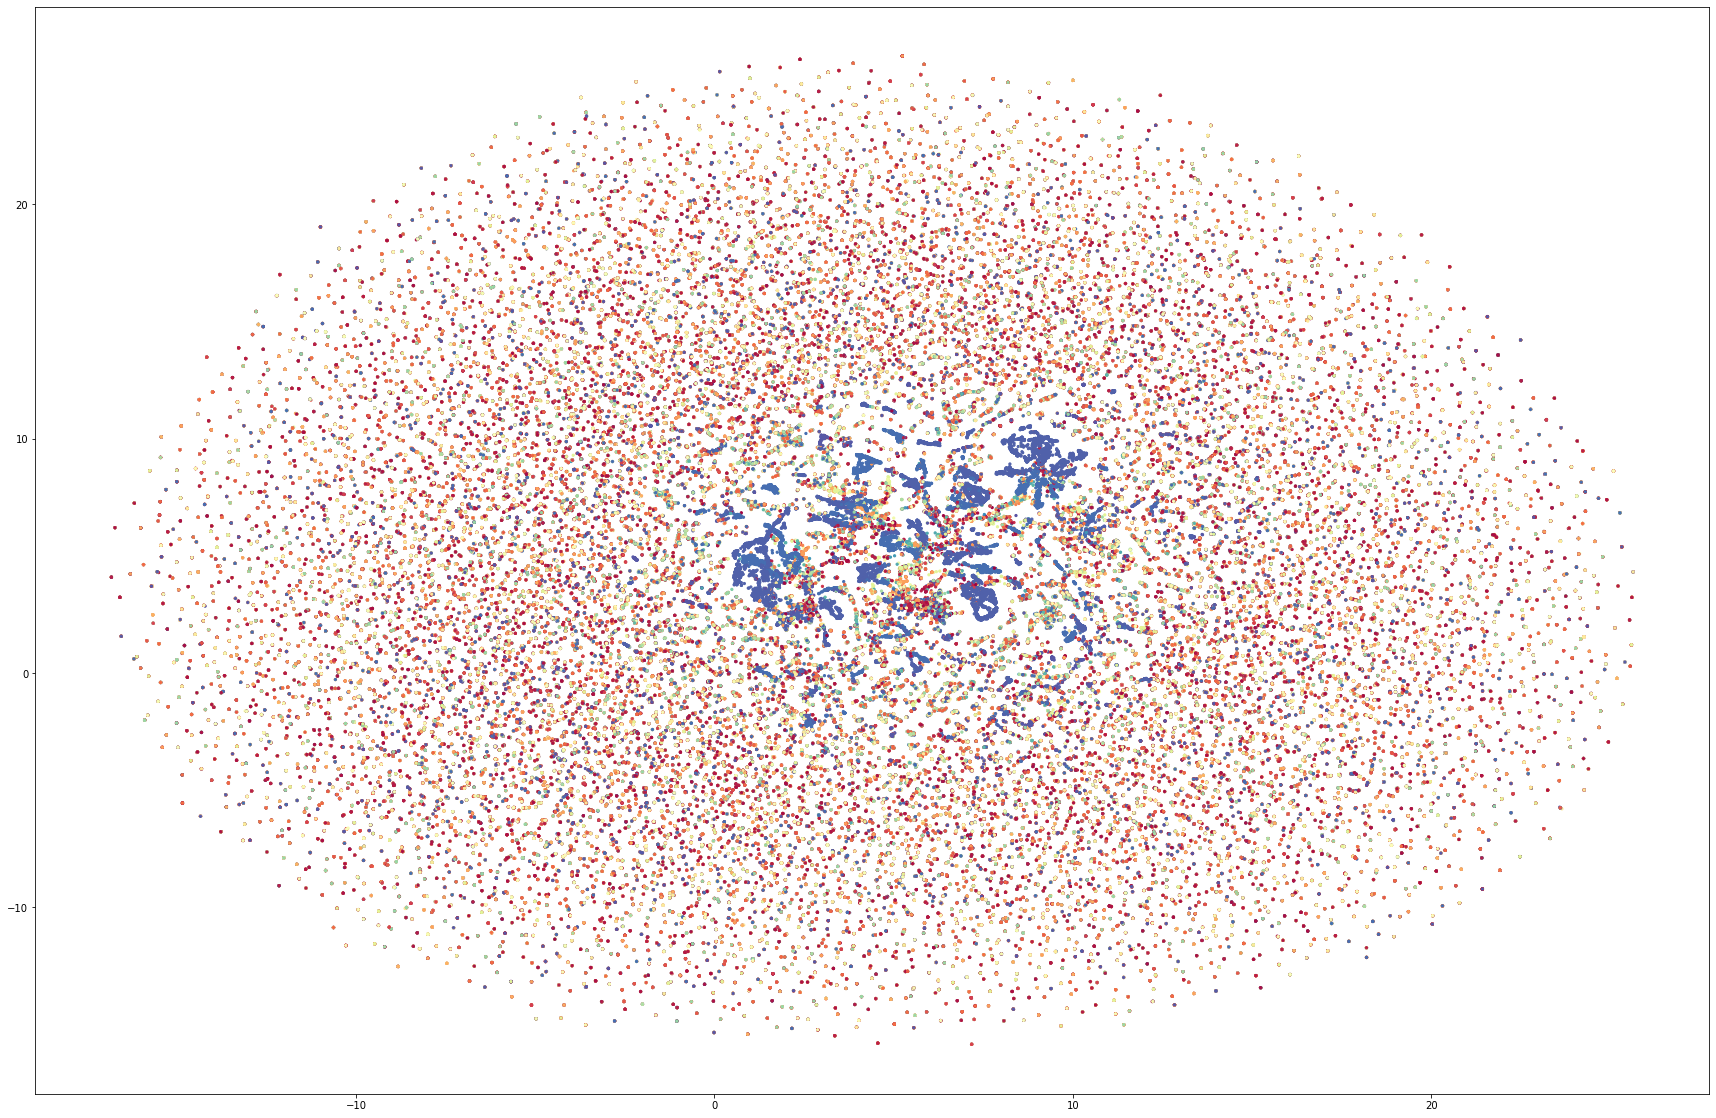

In [ ]:


plt.subplots(figsize=(30,20))

plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=filter_sample01[Y_NAME].astype(int), s=5, cmap='Spectral');

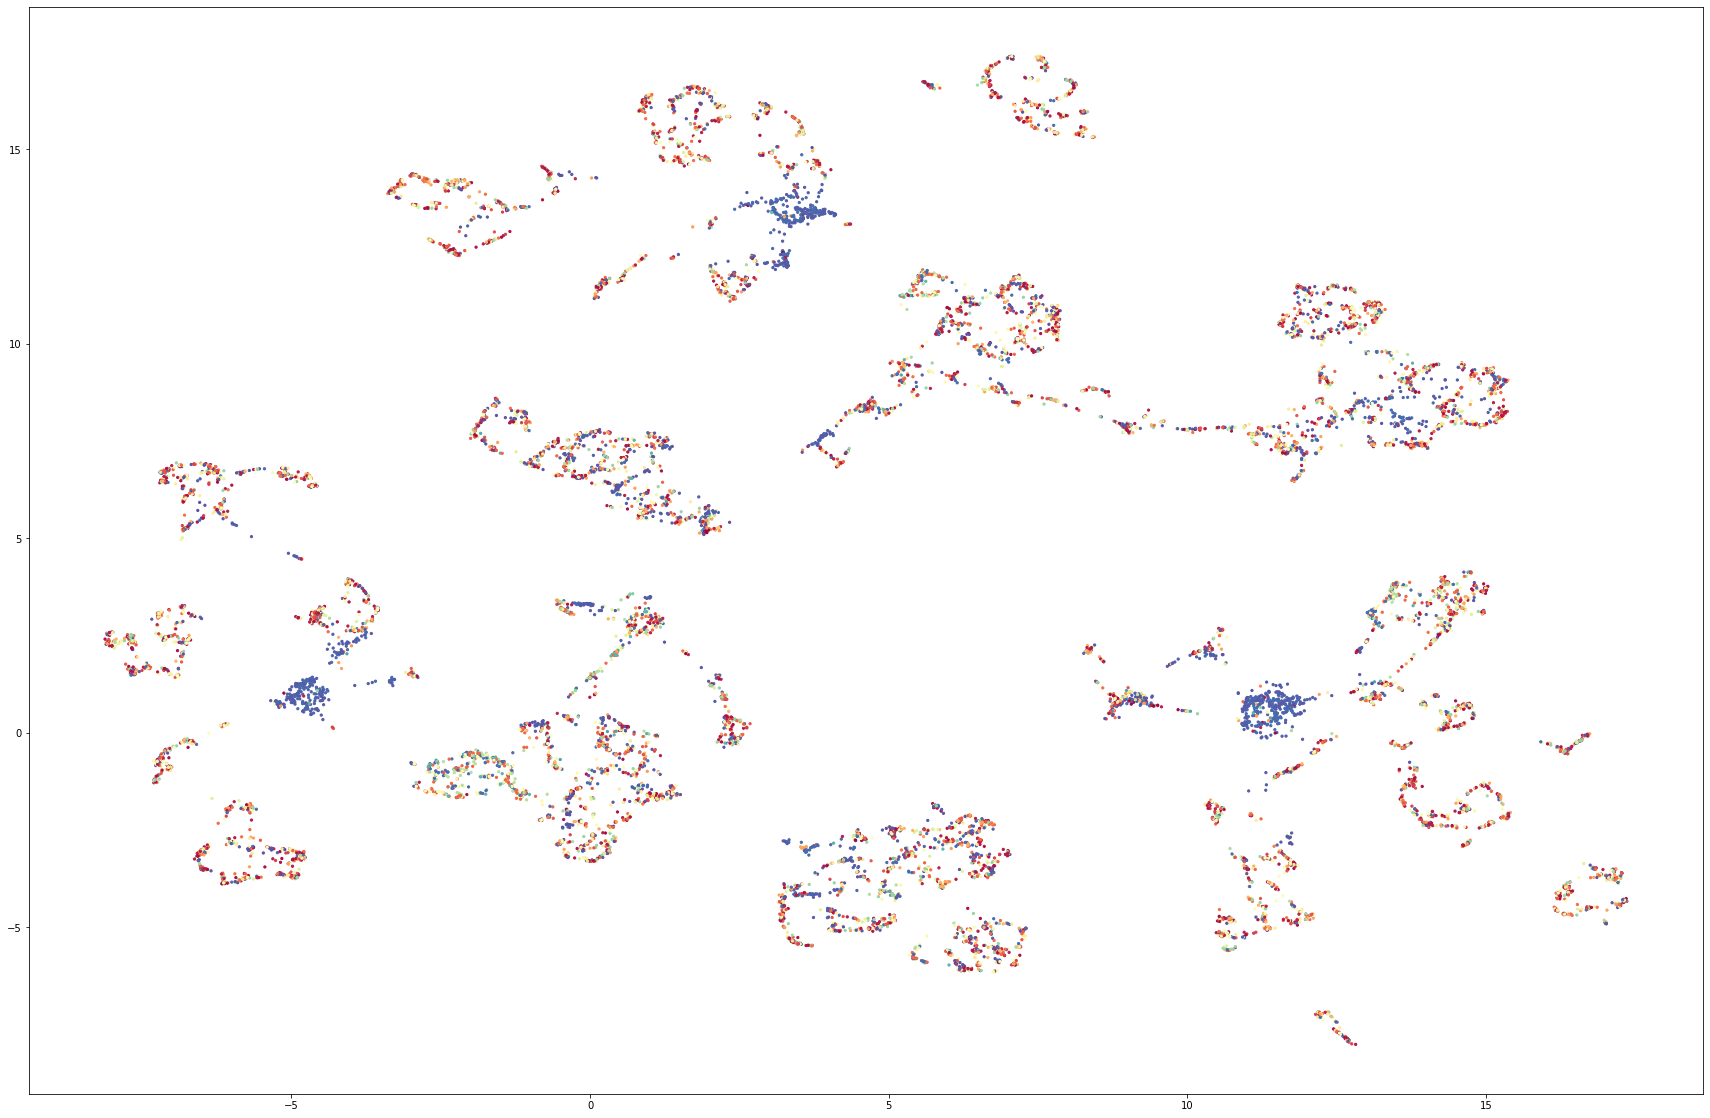

In [ ]:


plt.subplots(figsize=(30,20))

plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=filter_sample01[Y_NAME].astype(int), s=5, cmap='Spectral');

In [ ]:
G.edges


In [ ]:
len(G)
# a[a['source'] == "4"]



TypeError: ignored

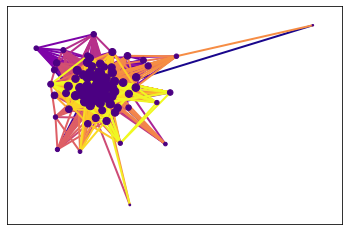

In [ ]:
import matplotlib as mpl

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)


In [ ]:
node_sizes_lst = np.asarray(node_sizes)*30

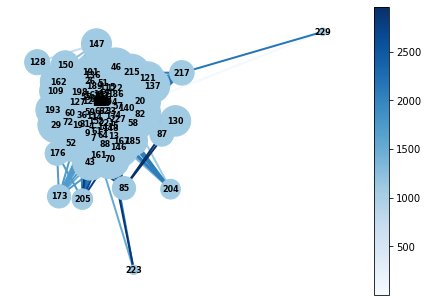

In [ ]:
cmap=plt.cm.Blues
vmin = min(edge_colors)
vmax = max(edge_colors)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=edge_colors, width=2, edge_cmap=cmap, node_size=node_sizes_lst,
           with_labels=True, font_size = 8, font_weight = 'bold', vmin=vmin, vmax=vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.show()